# Notebook 4: LSTM Modeling (Bitcoin Log Returns)

**Goal**
- Train LSTM model on log returns
- Compare performance with ARIMA
- Evaluate predictive capability

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

## 1) Load Data & Prepare Log Returns

In [3]:
df = pd.read_csv("C:/Projects/05_bitcoin_forecasting/data/btc_cleaned.csv", header=[0,1], index_col=0, parse_dates=True)
df.columns = ["Close"]

df["Log_Return"] = np.log(df["Close"] / df["Close"].shift(1))
df = df.dropna()

data = df["Log_Return"].values.reshape(-1,1)

## 2) Train/Test Split (Same as ARIMA)

In [4]:
train_size = int(len(data) * 0.8)

train_data = data[:train_size]
test_data = data[train_size:]

## 3) Scale Data

In [5]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

## 4) Create Time Windows

In [6]:
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 10

X_train, y_train = create_sequences(train_scaled, window_size)
X_test, y_test = create_sequences(test_scaled, window_size)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1450, 10, 1)
X_test shape: (356, 10, 1)


## 5) Build LSTM Model

In [7]:
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(window_size, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

c:\Users\shwey\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

## 6) Train Model

In [8]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0583
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103
Epoch 13/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104
Epoch 14/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104
Epoch 15/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103
Epoch 16/20
46/46 ━

## 7) Predict

In [9]:
predictions = model.predict(X_test)

# Inverse scale
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


## 8) Evaluation

In [10]:
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, predictions))
mae_lstm = mean_absolute_error(y_test_actual, predictions)

print("LSTM RMSE:", rmse_lstm)
print("LSTM MAE:", mae_lstm)

LSTM RMSE: 0.024638517020200455
LSTM MAE: 0.01691789409161538


## 9) Plot Forecast vs Actual

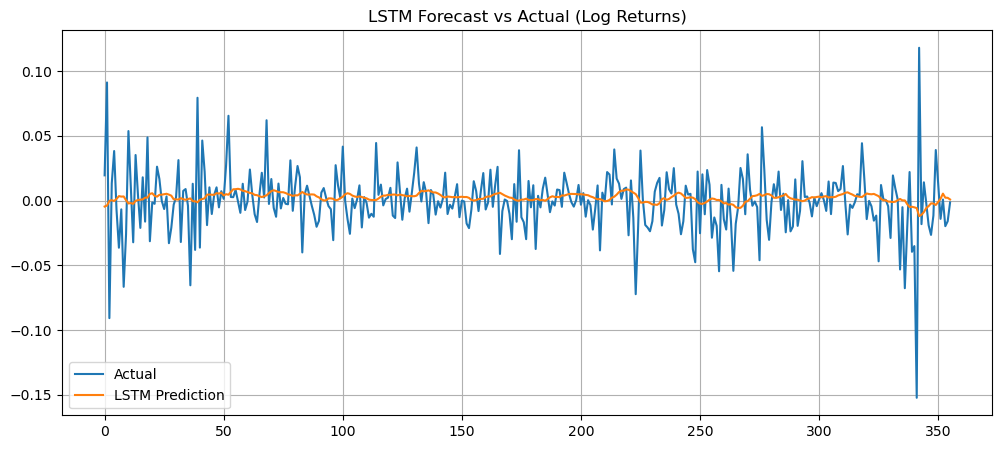

In [11]:
plt.figure(figsize=(12,5))
plt.plot(y_test_actual, label="Actual")
plt.plot(predictions, label="LSTM Prediction")
plt.title("LSTM Forecast vs Actual (Log Returns)")
plt.legend()
plt.grid(True)
plt.show()

### LSTM Model Performance

The LSTM model achieved RMSE = 0.02464 and MAE = 0.01692, which are nearly identical to both the ARIMA model and the naive zero-return baseline.

The forecasted values remain close to zero and fail to capture large volatility spikes. This suggests that Bitcoin log returns exhibit weak predictable structure, even when modeled using non-linear deep learning approaches.

Overall, both classical and deep learning models show limited ability to outperform a simple baseline in short-term return forecasting.